### Installation

In [ ]:
!pip install --upgrade datasets Pillow
!pip install pycocotools matplotlib
!pip install lightning
!pip install huggingface-hub==0.24.0
!pip install datasets pycocotools matplotlib

In [ ]:
!huggingface-cli login --token hf_xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

### Import utils

In [1]:
from datasets import load_dataset, concatenate_datasets, DatasetDict, ClassLabel
from pycocotools.coco import COCO
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import lightning as pl
import torch
from lightning import Trainer
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
from transformers import AutoFeatureExtractor
from transformers import AutoModelForObjectDetection
from tqdm import tqdm
from copy import deepcopy
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

/opt/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Dataset

In [29]:
dataset_dict = load_dataset(
    "detection-datasets/fashionpedia",
    cache_dir="./hf_cache"
)
print(dataset_dict.keys())
full_dataset = concatenate_datasets([dataset_dict[k] for k in dataset_dict])
print(f"Total images in full dataset: {len(full_dataset)}")

dict_keys(['train', 'val'])
Total images in full dataset: 46781


In [4]:
label_names = dataset_dict["train"].features["objects"].feature["category"].names
target_classes = {
    "glasses",
    "hat",
    "headband, head covering, hair accessory",
    "hood"
}
target_ids = [i for i, name in enumerate(label_names) if name.lower() in target_classes]
id_to_name = {i: label_names[i] for i in target_ids}
print("Target IDs:", target_ids)

Target IDs: [13, 14, 15, 27]


In [5]:
filtered_dataset_train = dataset_dict["train"].filter(
    lambda x: any(cat in target_ids for cat in x["objects"]["category"])
)
filtered_dataset_val   = dataset_dict["val"].filter(
    lambda x: any(cat in target_ids for cat in x["objects"]["category"])
)

In [6]:
def keep_only_target_objects(example):
    filtered_boxes = []
    filtered_labels = []
    filtered_area = []
    filtered_bbox_ids = []

    for i, label in enumerate(example["objects"]["category"]):
        if label in target_ids:
            filtered_labels.append(label)
            filtered_boxes.append(example["objects"]["bbox"][i])
            filtered_area.append(example["objects"]["area"][i])
            filtered_bbox_ids.append(example["objects"]["bbox_id"][i])

    # Overwrite the "objects" field
    example["objects"] = {
        "category": filtered_labels,
        "bbox": filtered_boxes,
        "area": filtered_area,
        "bbox_id": filtered_bbox_ids,
    }
    return example

dataset_train_cleaned = filtered_dataset_train.map(keep_only_target_objects)
dataset_eval_cleaned  = filtered_dataset_val.map(keep_only_target_objects)

In [7]:
headwear_dataset  = DatasetDict({
    "train": dataset_train_cleaned,
    "val": dataset_eval_cleaned
})

### Remap label

In [8]:
# New 0-indexed label mapping: {13: 0, 14: 1, 15: 2, 27: 3}
id_map = {orig_id: new_id for new_id, orig_id in enumerate(target_ids)}

def remap_labels(example):
    example["objects"]["category"] = [
        id_map[cat] for cat in example["objects"]["category"] if cat in id_map
    ]
    return example
headwear_dataset = headwear_dataset.map(remap_labels)

In [9]:
label_names = dataset_dict["train"].features["objects"].feature["category"].names
id_to_name = {new_id: label_names[old_id] for new_id, old_id in enumerate(target_ids)}
new_class_names = [id_to_name[i] for i in range(len(id_to_name))]

new_class_label = ClassLabel(num_classes=len(new_class_names), names=new_class_names)

In [10]:
# Copy current feature schema
new_features = deepcopy(headwear_dataset["train"].features)

# Overwrite the category class labels with your new ones
new_features["objects"].feature["category"] = new_class_label

# Cast both splits with new schema
headwear_dataset["train"] = headwear_dataset["train"].cast(new_features)
headwear_dataset["val"] = headwear_dataset["val"].cast(new_features)


* Quick view

In [11]:
print(headwear_dataset["train"].features["objects"].feature["category"].names)

['glasses', 'hat', 'headband, head covering, hair accessory', 'hood']


In [12]:
id_to_name

{0: 'glasses',
 1: 'hat',
 2: 'headband, head covering, hair accessory',
 3: 'hood'}

In [13]:
headwear_dataset['train'][0]['objects']

{'bbox_id': [158957],
 'category': [0],
 'bbox': [[284.0, 135.0, 372.0, 169.0]],
 'area': [1468]}

### Categories and Label Helper

In [ ]:
cats = headwear_dataset["train"].features['objects'].feature['category']
label_names = cats.names

# Filter to only classes actually present
used_label_ids = set()
for example in tqdm(headwear_dataset["train"]):
    used_label_ids.update(example["objects"]["category"])

included_label_ids = sorted(list(used_label_ids))
included_label_names = [label_names[i] for i in included_label_ids]

print("Fine-tuning on classes:", included_label_names)

def idx_to_text(indexes):
    return [label_names[i] for i in indexes]


### Load Feature Extractor

In [14]:
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=816, max_size=864)

/opt/anaconda3/lib/python3.11/site-packages/transformers/models/yolos/feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


### Transform Function & Utils

In [20]:
def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for _ in range(3)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0]] * 3))
    return ToPILImage()(t)

def xyxy_to_xcycwh(box):
    """
    Boxes in images may have the format (x1, y1, x2, y2) and we may need the format (center of x, center of y, width, height).
    :param box: Tensor-like box with format (x1, y1, x2, y2)
    :return: Tensor-like box with format (center of x, center of y, width, height)
    """
    x1, y1, x2, y2 = box.unbind(dim=1)
    w, h = x2 - x1, y2 - y1
    xc, yc = x1 + w * 0.5, y1 + h * 0.5
    return torch.stack([xc, yc, w, h], dim=1)

def rescale_bboxes(bboxes, size, down=True):
    """
    Boxes information contains values between 0 and 1 instead of values in pixels. This is made in order to make the boxes independant from the size of the image. 
    But we may need to re-escale the box.
    """
    w, h = size
    scale = torch.tensor([w, h, w, h], dtype=torch.float32)
    return (torch.tensor(bboxes) / scale if down else torch.tensor(bboxes) * scale)

def transform(batch):
    inputs = {}
    image = batch['image']
    image = fix_channels(ToTensor()(image[0]))
    inputs['pixel_values'] = feature_extractor([image], return_tensors='pt')['pixel_values']
    labels = []
    bbox = [rescale_bboxes(batch['objects'][i]['bbox'], (batch['width'][i], batch['height'][i])) for i in range(len(batch['objects']))]
    bbox = [xyxy_to_xcycwh(torch.Tensor(bbox_i)) for bbox_i in bbox]
    labels.append({
        "boxes": bbox,
        "class_labels": [object['category'] for object in batch['objects']],
        "image_id": torch.Tensor([batch['image_id']]).int(),
        "area": [object['area'] for object in batch['objects']],
        "iscrowd": torch.Tensor([0 for _ in batch['objects']]).int(),
        "orig_size": torch.Tensor([(batch['width'], batch['height'])]).int(),
        "size": torch.Tensor([inputs['pixel_values'].shape[1:]])[0].int(),
    })
    inputs['labels'] = labels
    return inputs

def plot_results(pil_img, boxes, class_labels):
    COLORS = ['lightcoral', 'yellowgreen', 'darkturquoise', 'hotpink', 'mediumslateblue']
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for (xmin, ymin, xmax, ymax), c, label in zip(boxes, colors, class_labels):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        ax.text(xmin, ymin, str(label), fontsize=15,
                bbox=dict(facecolor=c, alpha=0.5))
    plt.axis('off')
    plt.show()

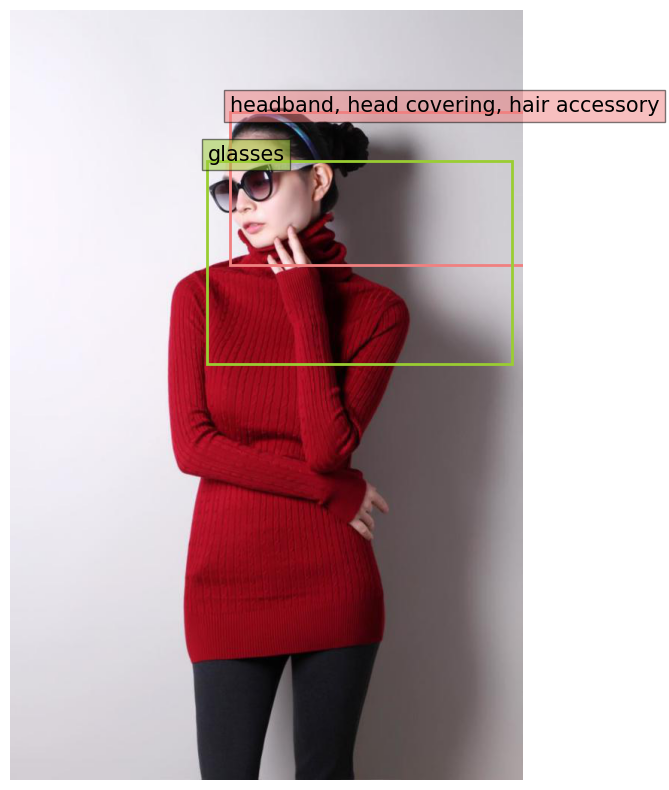

In [26]:
import random
sample = headwear_dataset["train"][random.randint(0, len(headwear_dataset["train"]) - 1)]

image = sample["image"]
width, height = sample["width"], sample["height"]
bboxes = []
for box in sample["objects"]["bbox"]:
    x, y, w, h = box
    x1, y1, x2, y2 = x, y, x + w, y + h
    bboxes.append([x1, y1, x2, y2])

labels = [new_class_names[label] for label in sample["objects"]["category"]]
plot_results(image, bboxes, labels)

### Apply transformation

In [ ]:
prepared_train = headwear_dataset["train"].with_transform(transform)
prepared_val   = headwear_dataset["val"].with_transform(transform)

### Create Dataloaders

In [ ]:
def collate_fn(batch):
    collated = {}
    collated["pixel_values"] = feature_extractor.pad([item['pixel_values'] for item in batch], return_tensors="pt")['pixel_values']
    collated["labels"] = []
    for item in batch:
        item['labels']['boxes'] = torch.stack(item['labels']['boxes'])[0]
        item['labels']['area'] = torch.Tensor(item['labels']['area'])
        item['labels']['class_labels'] = torch.Tensor(item['labels']['class_labels'])[0]
        item['labels']['class_labels'] = item['labels']['class_labels'].type(torch.LongTensor)
        collated["labels"].append(item['labels'])
    return collated

BATCH_SIZE = 1
train_dataloader = DataLoader(prepared_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(prepared_val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### Define Lightning Model

In [ ]:
class Detr(pl.LightningModule):
    def __init__(self, lr=2.5e-5, weight_decay=1e-4):
        super().__init__()
        self.model = AutoModelForObjectDetection.from_pretrained(
            "hustvl/yolos-small",
            num_labels=len(target_ids),
            ignore_mismatched_sizes=True
        )
        self.lr = lr
        self.weight_decay = weight_decay

    def forward(self, pixel_values):
        return self.model(pixel_values=pixel_values)

    def training_step(self, batch, batch_idx):
        outputs = self.model(pixel_values=batch["pixel_values"], labels=batch["labels"])
        self.log("train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self.model(pixel_values=batch["pixel_values"], labels=batch["labels"])
        self.log("val_loss", outputs.loss)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader


### Train the Model

In [ ]:
logger = CSVLogger(save_dir="./logs-metrics", name="yolos_run")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
    mode="min",
    filename="best-checkpoint"
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    mode="min",
    verbose=True
)

In [ ]:
model = Detr()
trainer = Trainer(
    max_epochs=10, 
    accelerator="gpu",  # mps, cpu, gpu
    devices=1, 
    logger=logger,
    callbacks=[checkpoint_callback, ] #early_stopping]
)
trainer.fit(model)

### Push to Hugging Face Hub

In [ ]:
model.model.config.id2label = id_to_name
model.model.config.label2id = {v: k for k, v in id_to_name.items()}
model.model.push_to_hub("Genereux-akotenou/yolos-headwear-2", private=False)